In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import unittest

from skimage.metrics import peak_signal_noise_ratio

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12})
torch.random.manual_seed(1904)
test = unittest.TestCase()

In [2]:
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(dev)

print(f'Using device {device}')

Using device cuda


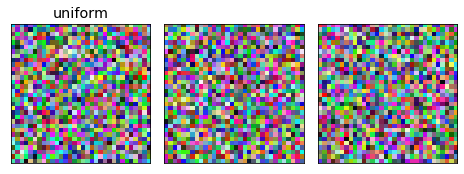

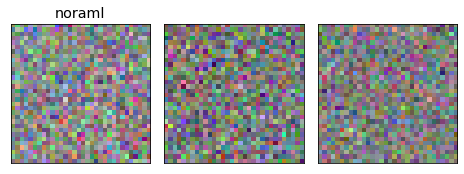

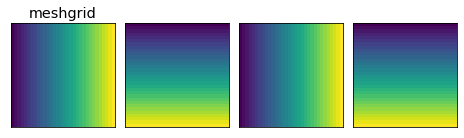

In [3]:
# Testing input generation
import utils
import input_gen as in_gen

# Uniform noise
imgs = []
uniform_noise = in_gen.get_noise(3, 32, 32, 'noise', 'uniform')
imgs.append(uniform_noise)
uniform_noise = in_gen.get_noise(3, 32, 32, 'noise', 'uniform')
imgs.append(uniform_noise)
uniform_noise = in_gen.get_noise(3, 32, 32, 'noise', 'uniform')
imgs.append(uniform_noise)
fig, axes = utils.tensors_as_images(imgs, titles=['uniform'])

# Normal noise
imgs = []
normal_noise = in_gen.get_noise(3, 32, 32, 'noise', 'normal')
imgs.append(normal_noise)
normal_noise = in_gen.get_noise(3, 32, 32, 'noise', 'normal')
imgs.append(normal_noise)
normal_noise = in_gen.get_noise(3, 32, 32, 'noise', 'normal')
imgs.append(normal_noise)
fig, axes = utils.tensors_as_images(imgs, titles=['noraml'])

# Meshgrid
imgs = []
meshgrid_input = in_gen.get_noise(3, 32, 32, 'meshgrid')
imgs.append(meshgrid_input[0].unsqueeze(dim=0))
imgs.append(meshgrid_input[1].unsqueeze(dim=0))
meshgrid_input = in_gen.get_noise(3, 32, 32, 'meshgrid')
imgs.append(meshgrid_input[0].unsqueeze(dim=0))
imgs.append(meshgrid_input[1].unsqueeze(dim=0))
fig, axes = utils.tensors_as_images(imgs, titles=['meshgrid'])



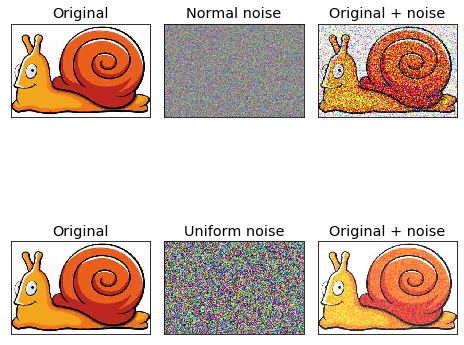

In [4]:
# Testing adding noise to image
from utils import *
from input_gen import *

fname_snail = 'data/denoising/snail.jpg'

img_pil = crop_image(get_image(fname_snail, -1)[0])
img_np = pil_to_np(img_pil)
img_tr = torch.from_numpy(img_np)
img_noisy_normal, normal_noise = add_noise_to_tensor(img_tr, 'normal', std=0.3)
img_noisy_uniform, uniform_noise = add_noise_to_tensor(img_tr, 'uniform', std=0.3)
fig, axes = utils.tensors_as_images([img_tr, normal_noise, img_noisy_normal, img_tr,
                                     uniform_noise, img_noisy_uniform], 
                                    titles=['Original', 'Normal noise', 'Original + noise',
                                            'Original', 'Uniform noise', 'Original + noise'], nrows=2,
                                   hspace=0)

In [5]:
from models import *
from models.unet import *
IMAGE = 'jet'

if IMAGE == 'snail':
    net = UNet(3, 3, [8, 16, 32, 64, 128], [8, 16, 32, 64, 128], [0, 0, 0, 4, 4],
              [3, 3, 3, 3, 3], [3, 3, 3, 3, 3], [None, None, None, 1, 1], weight_std=1./30)
elif IMAGE == 'jet':
    net = UNet(3, 3, [128]*5, [128]*5, [4]*5,
              [3]*5, [3]*5, [1]*5, weight_std=1./30)
else:
    assert False
net.to(device)
print(net)

UNet(
  (downs): ModuleList(
    (0): DownsampleBlock(
      (conv1): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.1)
      )
      (conv2): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.1)
      )
    )
    (1): DownsampleBlock(
      (conv1): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.1)
      )
      (conv2): ConvBlock(
 

In [6]:
s = sum([np.prod(list(p.size())) for p in net.parameters()])
print(f'Number of params: {s}')

# Loss 
mse = torch.nn.MSELoss()

Number of params: 2840167


In [7]:
# change IMAGE to jet for jet image or snail for snail image

reg_noise_std = 1./30.
fname_snail = 'data/denoising/snail.jpg'
fname_jet = 'data/denoising/F16_GT.png'
fname = fname_snail if IMAGE == 'snail' else fname_jet
use_noise = False if IMAGE == 'snail' else True
img_pil = crop_image(get_image(fname, -1)[0])
img_np = pil_to_np(img_pil)
img_tr = torch.from_numpy(img_np)
target_img = img_tr
if use_noise:
    target_noisy_img, _ = add_noise_to_tensor(target_img, 'normal', std=reg_noise_std)
else:
    target_noisy_img = target_img
target_noisy_img = target_noisy_img.unsqueeze(dim=0).to(device)
net_input = get_noise(*img_tr.shape, method='noise').unsqueeze(dim=0).detach().to(device)
noise = net_input.detach().clone()
if reg_noise_std > 0:
        net_input = net_input + (noise.normal_() * reg_noise_std)

C:\Users\User\Miniconda3\envs\cs236781-hw\lib\site-packages\torch\nn\functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Iteration 100   Loss = 0.007347565144300461   PSNR = 21.33856557706994343
Iteration 200   Loss = 0.003738338127732277   PSNR = 24.273214502553007074
Iteration 300   Loss = 0.003036413574591279   PSNR = 25.176390851846848454
Iteration 400   Loss = 0.0026210176292806864   PSNR = 25.81530035543397676
Iteration 500   Loss = 0.0023402238730341196   PSNR = 26.30742608833158584
Iteration 600   Loss = 0.0022135309409350157   PSNR = 26.54914439366618185
Iteration 700   Loss = 0.002206346020102501   PSNR = 26.563263703761628286
Iteration 800   Loss = 0.0020247516222298145   PSNR = 26.93628217686345453
Iteration 900   Loss = 0.001965924398973584   PSNR = 27.064331927219252517
Iteration 1000   Loss = 0.0019323235610499978   PSNR = 27.1392014954428282
Iteration 1100   Loss = 0.0018282769015058875   PSNR = 27.37958013344113838
Iteration 1200   Loss = 0.0018294528126716614   PSNR = 27.37678803035827474
Iteration 1300   Loss = 0.0017573884688317776   PSNR = 27.55132216069353534
Iteration 1400   Loss =

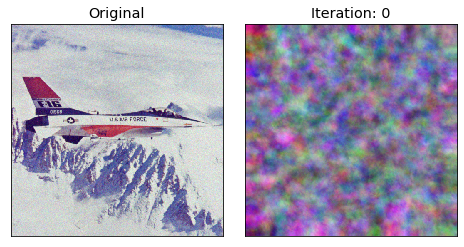

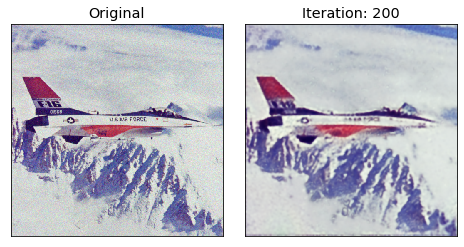

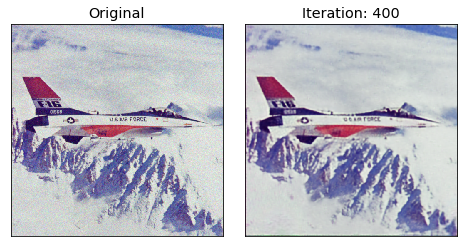

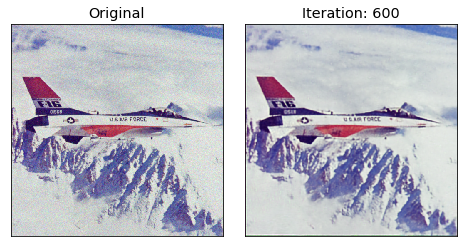

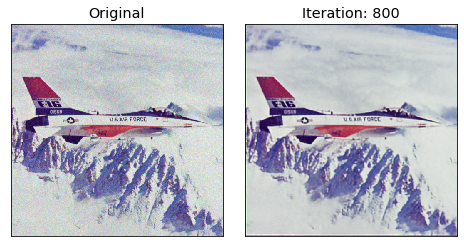

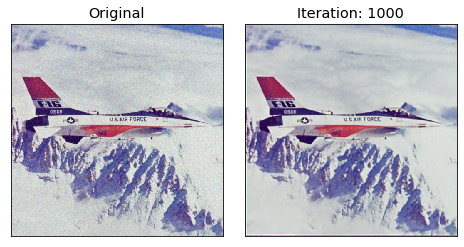

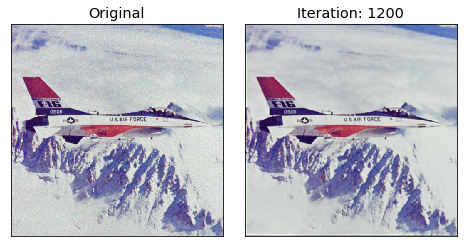

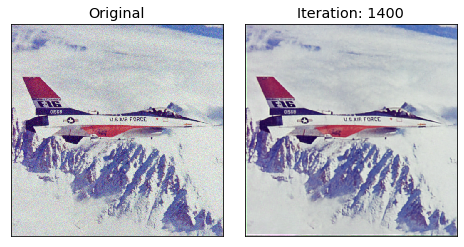

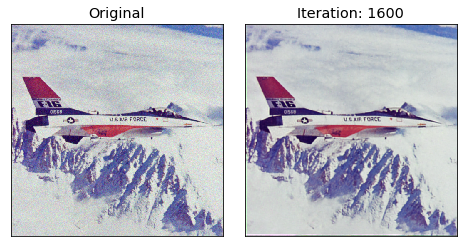

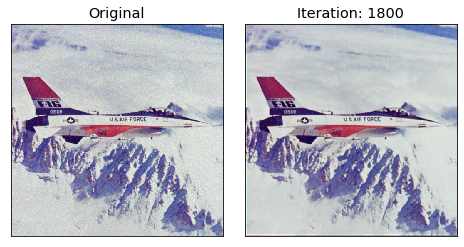

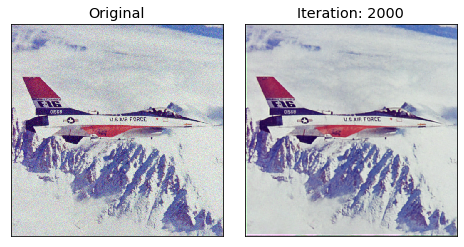

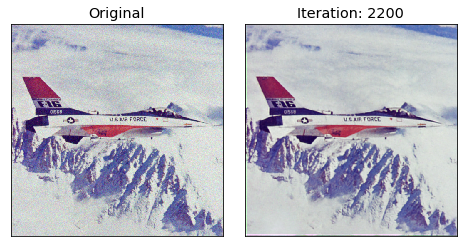

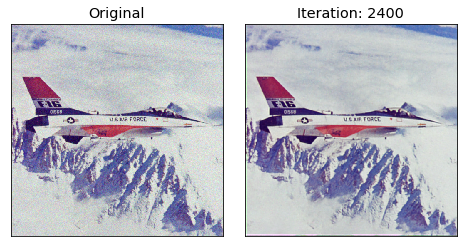

In [8]:
# Training loop, can change hyperparameters mid way
parameters = [x for x in net.parameters()]
LR = 0.01
num_iter = 2400
show_every = 100
optimizer = torch.optim.Adam(parameters, lr=LR)
for i in range(num_iter):
    optimizer.zero_grad()
    out = net(net_input)
    loss = mse(out, target_noisy_img)
    loss.backward()
    psnr_noisy = peak_signal_noise_ratio(target_noisy_img.detach().cpu().numpy()[0],
                                         out.detach().cpu().numpy()[0])
    optimizer.step()
    print('Iteration' , i, '   Loss =', loss.item(), '   PSNR =', psnr_noisy, end='\r')
    if i % show_every == 0 and i:
        print(f'Iteration {i}   Loss = {loss.item()}   PSNR = {psnr_noisy}')
    if i % (show_every*2) == 0:
        fig, axes = utils.tensors_as_images([target_noisy_img[0], out[0].detach()], 
                                        titles=['Original', f'Iteration: {i}'])
print(f'Done training final Loss = {loss.item()}   PSNR = {psnr_noisy}')
fig, axes = utils.tensors_as_images([target_noisy_img[0], out[0].detach()], 
                                        titles=['Original', f'Iteration: {num_iter}'])

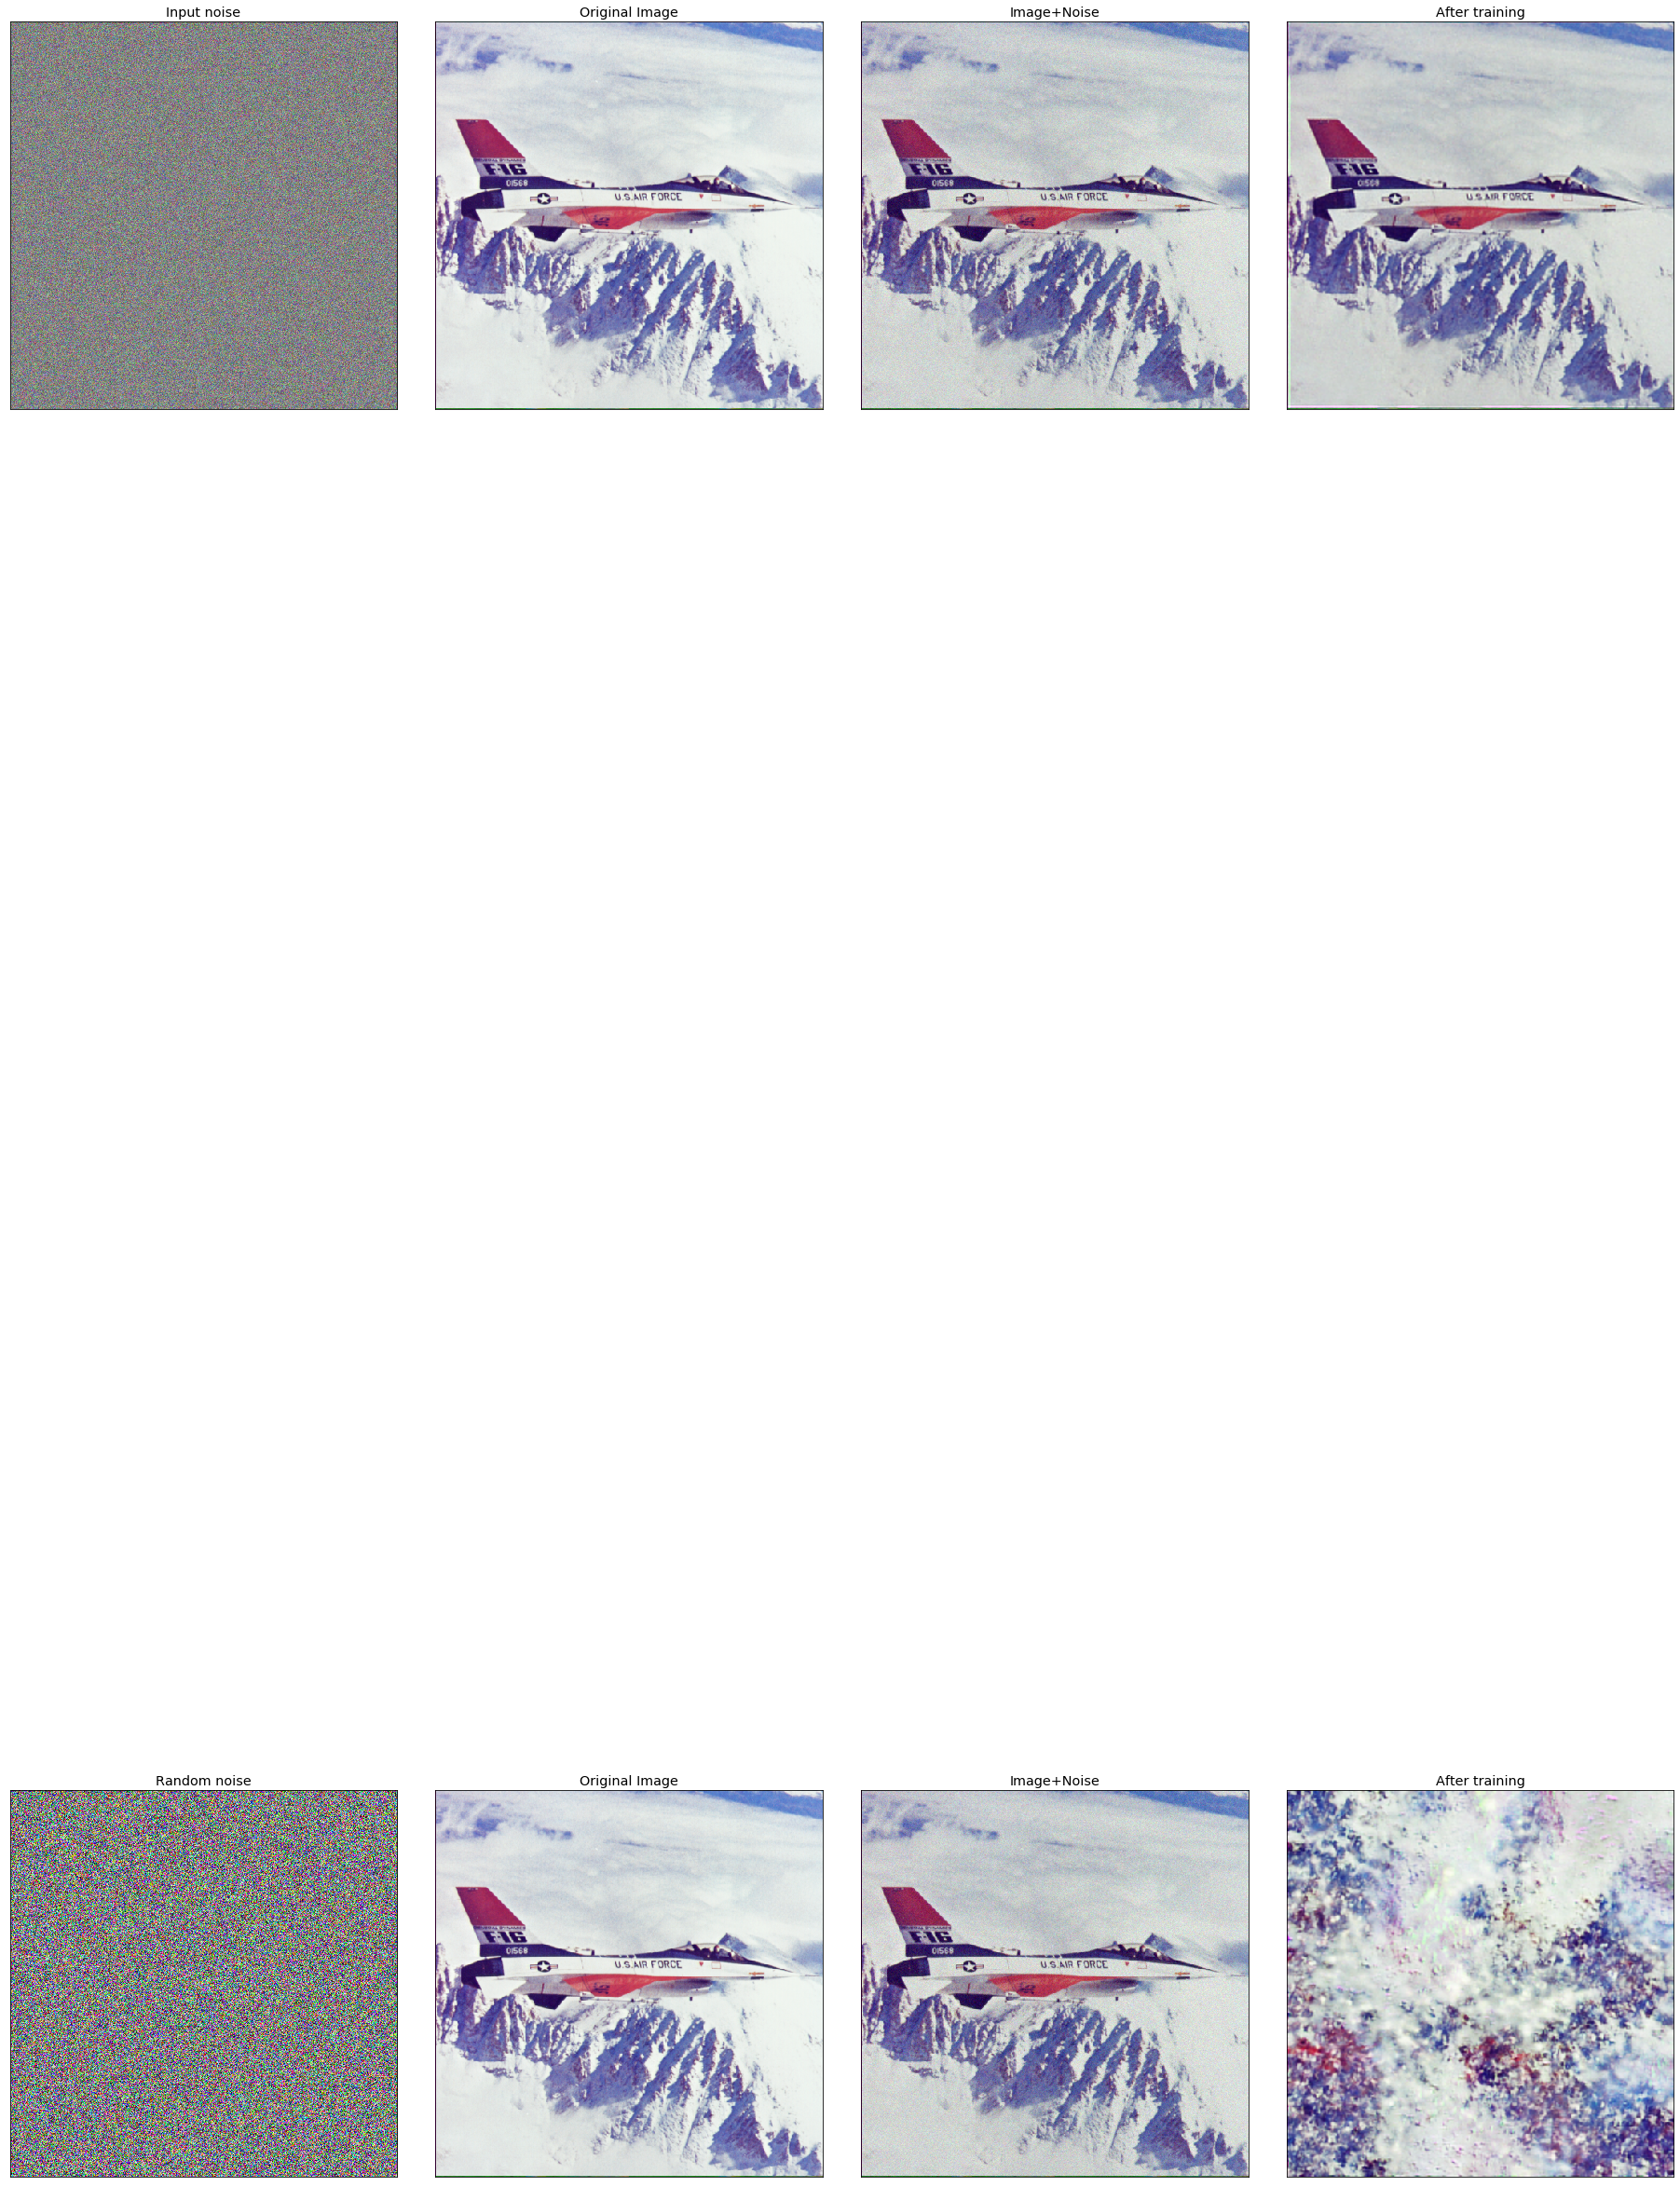

In [9]:
# Showing result of the training using original noise and random noise
with torch.no_grad():
    original_noise = net_input
    output1 = net(original_noise).detach()
    output1 = output1.squeeze(dim=0)
    random_noise = get_noise(*net_input.shape[1:], method='noise').unsqueeze(dim=0)
    output2 = net(random_noise.to(device)).detach()
    output2 = output2.squeeze(dim=0)
    fig, axes = utils.tensors_as_images([original_noise.squeeze(dim=0), img_tr, target_noisy_img.squeeze(dim=0), output1, 
                                         random_noise.squeeze(dim=0), img_tr, target_noisy_img.squeeze(dim=0), output2], 
                                        titles=['Input noise', 'Original Image', 'Image+Noise', 'After training', 
                                               'Random noise', 'Original Image', 'Image+Noise', 'After training'], nrows=2, figsize=(32,64))
    output_pil = np_to_pil(output1.detach().cpu().numpy())
    output_pil.save(f'results/denoising/{IMAGE}.png')
# will need to use original noise to do denoising

In [11]:
# Try to get better results by changing z_input a bit
with torch.no_grad():
    a = torch.rand(*original_noise.shape)  
    best_psnr = 0
    best_p = 0
    results = []
    values = [0, 0.005, 0.006, 0.007,0.008,0.01,0.012, 0.014, 0.016,
              0.02,0.025,0.03,0.04,0.05,0.1,0.2]
    for p in reversed(values):
        a[abs(a) > p] = 0
        new_noise = original_noise + a.to(device)
        output = net(new_noise).detach()
        psnr_noisy = peak_signal_noise_ratio(target_noisy_img.detach().cpu().numpy()[0],
                                             output.detach().cpu().numpy()[0])
        output = output.squeeze(dim=0)
        results.append(output.clone())
        #print(f'With new noise PSNR = {psnr_noisy}')
        if psnr_noisy > best_psnr:
            best_psnr = psnr_noisy
            best_p = p
    print(f' Best PSNR = {best_psnr}   Best p = {best_p}')
    nrows = int(len(values)/4)
    fig, axes = utils.tensors_as_images(results, titles=[f'p={p}' for p in reversed(values)],
                                        nrows=nrows, figsize=(32,32))
        

RuntimeError: Expected object of device type cuda but got device type cpu for argument #1 'self' in call to _thnn_conv2d_forward